[Original author](https://inria.github.io/scikit-learn-mooc/python_scripts/logistic_regression.html)
Under a CC-BY License by Inria Learning Lab, scikit-learn @ La Fondation Inria, Inria Academy.

In regression, we saw that the target to be predicted is a continuous variable. In classification, the target is discrete (e.g. categorical).  

In this notebook we go back to the penguin dataset. However, this time the task is to predict the penguin species using the culmen information. We also simplify our classification problem by selecting only 2 of the penguin species to solve a binary classification problem.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving penguins_size.csv to penguins_size.csv


In [ ]:
import pandas as pd
penguins = pd.read_csv('penguins_size.csv')

In [ ]:
penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [ ]:
penguins.shape

(344, 7)

penguins.set_index("species"): This sets the "species" column as the index of the DataFrame. It means that the "species" column will be used as the row labels.  
  
.loc[["Adelie", "Chinstrap"]]: This selects only the rows where the index (now set to "species") is either "Adelie" or "Chinstrap". It filters the DataFrame to include only these two penguin species.  
  
.reset_index(): This resets the index of the resulting DataFrame back to the default integer index. This operation is often used to revert the changes made by the set_index method.  
  
So, the overall result is that you are creating a new DataFrame with only the rows corresponding to the "Adelie" and "Chinstrap" penguin species from the original penguins DataFrame, and the index is reset to the default integer index.

In [ ]:
# only keep the Adelie and Chinstrap classes
penguins = (
    penguins.set_index("species").loc[["Adelie", "Chinstrap"]].reset_index()
)
culmen_columns = ["culmen_length_mm", "culmen_depth_mm"]
target_column = "species"

In [ ]:
penguins.shape

(220, 7)

We can quickly start by visualizing the feature distribution by class:

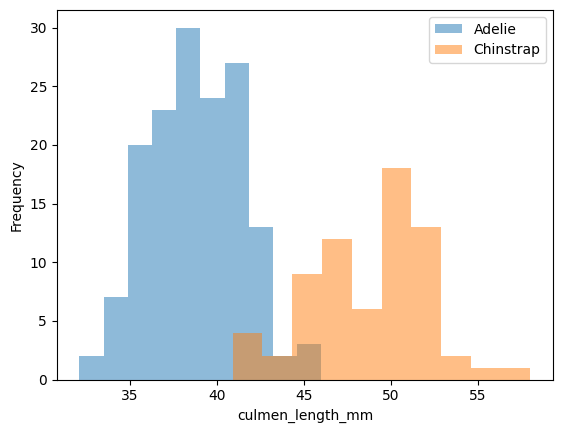

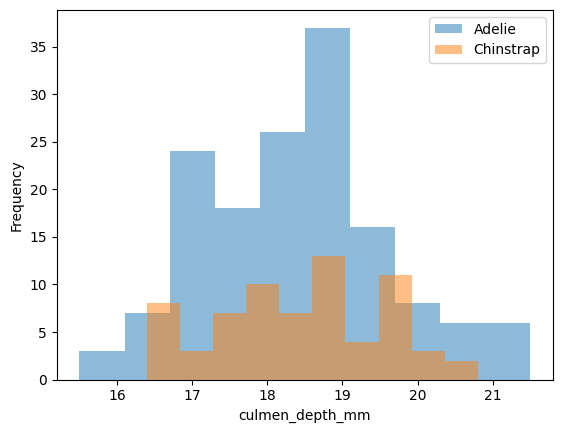

In [ ]:
import matplotlib.pyplot as plt

for feature_name in culmen_columns:
    plt.figure()
    # plot the histogram for each specie
    penguins.groupby("species")[feature_name].plot.hist(alpha=0.5, legend=True)
    plt.xlabel(feature_name)

We can observe that we have quite a simple problem. When the culmen length increases, the probability that the penguin is a Chinstrap is closer to 1. However, the culmen depth is not helpful for predicting the penguin species.

For model fitting, we separate the target from the data and we create a training and a testing set.

We drop rows with missing data (warning: this shouldn't be done lightly without having explored the missingness of the data, here we are doing for simplicity and to focus on the modelling).

In [ ]:
penguins = penguins.dropna()

In [ ]:
from sklearn.model_selection import train_test_split

penguins_train, penguins_test = train_test_split(penguins, random_state=0)

data_train = penguins_train[culmen_columns]
data_test = penguins_test[culmen_columns]

target_train = penguins_train[target_column]
target_test = penguins_test[target_column]

The linear regression that we previously saw predicts a continuous output. When the target is a binary outcome, one can use the logistic function to model the probability. This model is known as logistic regression.  
  
Scikit-learn provides the class LogisticRegression which implements this algorithm.

In scikit-learn, a pipeline is a way to streamline a lot of routine processes by putting together a sequence of data processing steps.   
  
  make_pipeline is a convenient function for creating a pipeline without having to explicitly name each step. It automatically generates names for each step based on the names of the classes or functions provided.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

logistic_regression = make_pipeline(StandardScaler(), LogisticRegression())
logistic_regression.fit(data_train, target_train)
accuracy = logistic_regression.score(data_test, target_test)
print(f"Accuracy on test set: {accuracy:.3f}")

Accuracy on test set: 0.981


Since we are dealing with a classification problem containing only 2 features, it is then possible to observe the decision function boundary. The boundary is the rule used by our predictive model to affect a class label given the feature values of the sample.

Here, we use the class DecisionBoundaryDisplay. This educational tool allows us to gain some insights by plotting the decision function boundary learned by the classifier in a 2 dimensional feature space.

Notice however that in more realistic machine learning contexts, one would typically fit on more than two features at once and therefore it would not be possible to display such a visualization of the decision boundary in general.

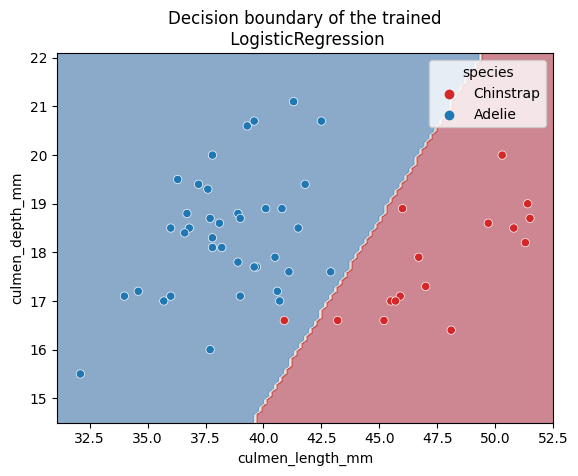

In [ ]:
import seaborn as sns
from sklearn.inspection import DecisionBoundaryDisplay

DecisionBoundaryDisplay.from_estimator(
    logistic_regression,
    data_test,
    response_method="predict",
    cmap="RdBu_r",
    alpha=0.5,
)
sns.scatterplot(
    data=penguins_test,
    x=culmen_columns[0],
    y=culmen_columns[1],
    hue=target_column,
    palette=["tab:red", "tab:blue"],
)
_ = plt.title("Decision boundary of the trained\n LogisticRegression")

Thus, we see that our decision function is represented by a straight line separating the 2 classes.

For the mathematically inclined reader, the equation of the decision boundary is:

coef0 * x0 + coef1 * x1 + intercept = 0

where x0 is "culmen_length_mm" and x1 is "culmen_depth_mm".

This equation is equivalent to (assuming that coef1 is non-zero):

x1 = coef0 / coef1 * x0 - intercept / coef1

which is the equation of a straight line.

Since the line is oblique, it means that both coefficients (also called weights) are non-null:

In [ ]:
logistic_regression[-1].intercept_, logistic_regression[-1].coef_

(array([-1.64106597]), array([[ 3.89531951, -1.05309894]]))

In [ ]:
coefs = logistic_regression[-1].coef_[0] # Accesses the last element of the logistic_regression pipeline and the [0] index is used assuming there is only one class (binary classification).
weights = pd.Series(coefs, index=[f"Weight for '{c}'" for c in culmen_columns])
weights

Weight for 'culmen_length_mm'    3.895320
Weight for 'culmen_depth_mm'    -1.053099
dtype: float64

You can access [pipeline steps](https://scikit-learn.org/stable/modules/compose.html#access-pipeline-steps) by name or position. In the code above logistic_regression[-1] means the last step of the pipeline. Then you can access the attributes of that step such as coef_. Notice also that the coef_ attribute is an array of shape (1, n_features) an then we access it via its first entry. Alternatively one could use coef_.ravel().

We are now ready to visualize the weight values as a barplot:

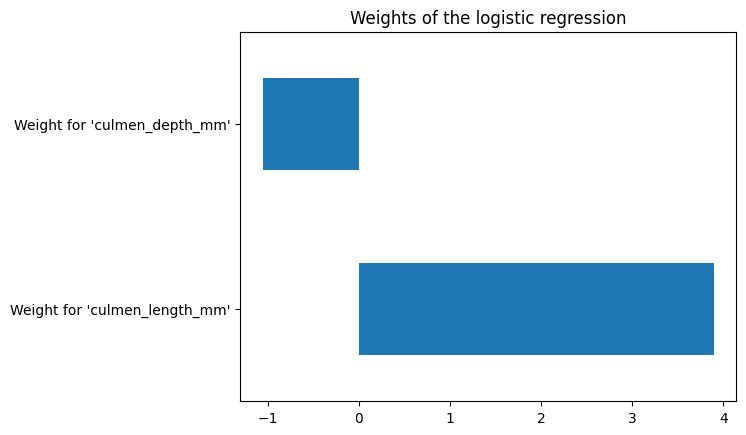

In [ ]:
weights.plot.barh()
_ = plt.title("Weights of the logistic regression")

If one of the weights had been zero, the decision boundary would have been either horizontal or vertical.

Furthermore the intercept is also non-zero, which means that the decision does not go through the point with (0, 0) coordinates.

### (Estimated) predicted probabilities

The predict method in classification models returns what we call a “hard class prediction”, i.e. the most likely class a given data point would belong to. We can confirm the intuition given by the DecisionBoundaryDisplay by testing on a hypothetical sample:

In [ ]:
test_penguin = pd.DataFrame(
    {"culmen_length_mm": [45], "culmen_depth_mm": [17]}
)
logistic_regression.predict(test_penguin)

array(['Chinstrap'], dtype=object)

In this case, our logistic regression classifier predicts the Chinstrap species. Note that this agrees with the decision boundary plot above: the coordinates of this test data point match a location close to the decision boundary, in the red region.



one can alternatively use the predict_proba method to compute continuous values (“soft predictions”) that correspond to an estimation of the confidence of the target belonging to each class.

For a binary classification scenario, the logistic regression makes both hard and soft predictions based on the [logistic function](https://en.wikipedia.org/wiki/Logistic_function) (also called sigmoid function), which is S-shaped and maps any input into a value between 0 and 1.

In [ ]:
y_pred_proba = logistic_regression.predict_proba(test_penguin)
y_pred_proba

array([[0.18046337, 0.81953663]])

More in general, the output of predict_proba is an array of shape (n_samples, n_classes)

In [ ]:
y_pred_proba.shape

(1, 2)

Also notice that the sum of (estimated) predicted probabilities across classes is 1.0 for each given sample.

For multi-class classification the logistic regression uses the [softmax function](https://en.wikipedia.org/wiki/Softmax_function) to make predictions.

In [40]:
target_test.value_counts()

Adelie       38
Chinstrap    16
Name: species, dtype: int64

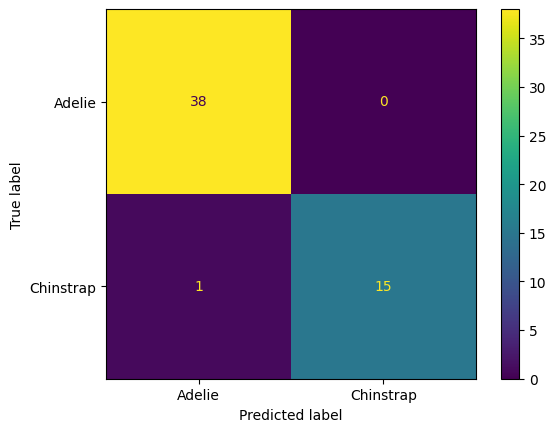

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay

_ = ConfusionMatrixDisplay.from_estimator(logistic_regression, data_test, target_test)

In [49]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
target_predicted = logistic_regression.predict(data_test)
print("Accuracy:",metrics.accuracy_score(target_test, target_predicted))
print("Precision:",metrics.precision_score(target_test, target_predicted, pos_label='Chinstrap'))
print("Recall:",metrics.recall_score(target_test, target_predicted, pos_label='Chinstrap'))

Accuracy: 0.9814814814814815
Precision: 1.0
Recall: 0.9375


In [46]:
target_predicted

array(['Chinstrap', 'Adelie', 'Adelie', 'Adelie', 'Chinstrap', 'Adelie',
       'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie',
       'Chinstrap', 'Adelie', 'Adelie', 'Chinstrap', 'Adelie', 'Adelie',
       'Chinstrap', 'Chinstrap', 'Chinstrap', 'Adelie', 'Chinstrap',
       'Chinstrap', 'Adelie', 'Adelie', 'Chinstrap', 'Adelie', 'Adelie',
       'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie',
       'Chinstrap', 'Adelie', 'Chinstrap', 'Adelie', 'Chinstrap',
       'Adelie', 'Chinstrap', 'Adelie', 'Adelie', 'Adelie', 'Adelie',
       'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie',
       'Chinstrap', 'Adelie'], dtype=object)

In [47]:
target_test

203    Chinstrap
42        Adelie
95        Adelie
182    Chinstrap
176    Chinstrap
81        Adelie
102       Adelie
143       Adelie
6         Adelie
89        Adelie
61        Adelie
151       Adelie
166    Chinstrap
118       Adelie
80        Adelie
208    Chinstrap
132       Adelie
17        Adelie
159    Chinstrap
164    Chinstrap
174    Chinstrap
147       Adelie
200    Chinstrap
195    Chinstrap
150       Adelie
23        Adelie
214    Chinstrap
20        Adelie
92        Adelie
77        Adelie
12        Adelie
69        Adelie
149       Adelie
103       Adelie
142       Adelie
168    Chinstrap
38        Adelie
160    Chinstrap
96        Adelie
197    Chinstrap
112       Adelie
186    Chinstrap
145       Adelie
21        Adelie
141       Adelie
128       Adelie
27        Adelie
86        Adelie
51        Adelie
82        Adelie
5         Adelie
114       Adelie
202    Chinstrap
50        Adelie
Name: species, dtype: object